In [1]:
# Import required libraries
import numpy as np
import matplotlib.pyplot as plt
from src.data_loader import load_and_preprocess_mnist
from src.models.kmeans import KMeans
from src.visualization import plot_clusters

np.random.seed(42)

## 1. Load and Prepare Data

K-means works with continuous data, so grayscale (not binarized) images are used.

In [2]:
# Load data
X_train, y_train, X_test, y_test = load_and_preprocess_mnist(
    n_samples=5000,
    binarize=False,  # Use grayscale for K-means
    flatten=True
)

print(f"Training data: {X_train.shape}")
print(f"Test data: {X_test.shape}")

Training data: (5000, 784)
Test data: (10000, 784)


## 2. Fit K-Means Model

Cluster into 10 groups (matching the 10 digit classes), though K-means doesn't know about the true labels.

In [3]:
# Initialize and fit K-means
kmeans = KMeans(n_clusters=10, max_iters=300, random_state=42)
kmeans.fit(X_train)

print(f"Converged in {kmeans.n_iter_} iterations")
print(f"Cluster centers shape: {kmeans.cluster_centers_.shape}")
print(f"\nCluster sizes:")
unique, counts = np.unique(kmeans.labels_, return_counts=True)
for cluster, count in zip(unique, counts):
    print(f"  Cluster {cluster}: {count} samples ({count/len(kmeans.labels_)*100:.1f}%)")

Converged in 26 iterations
Cluster centers shape: (10, 784)

Cluster sizes:
  Cluster 0: 399 samples (8.0%)
  Cluster 1: 496 samples (9.9%)
  Cluster 2: 661 samples (13.2%)
  Cluster 3: 359 samples (7.2%)
  Cluster 4: 378 samples (7.6%)
  Cluster 5: 458 samples (9.2%)
  Cluster 6: 594 samples (11.9%)
  Cluster 7: 527 samples (10.5%)
  Cluster 8: 559 samples (11.2%)
  Cluster 9: 569 samples (11.4%)


## 3. Visualize Learned Cluster Centers

Each cluster center represents the "average" digit assigned to that cluster.

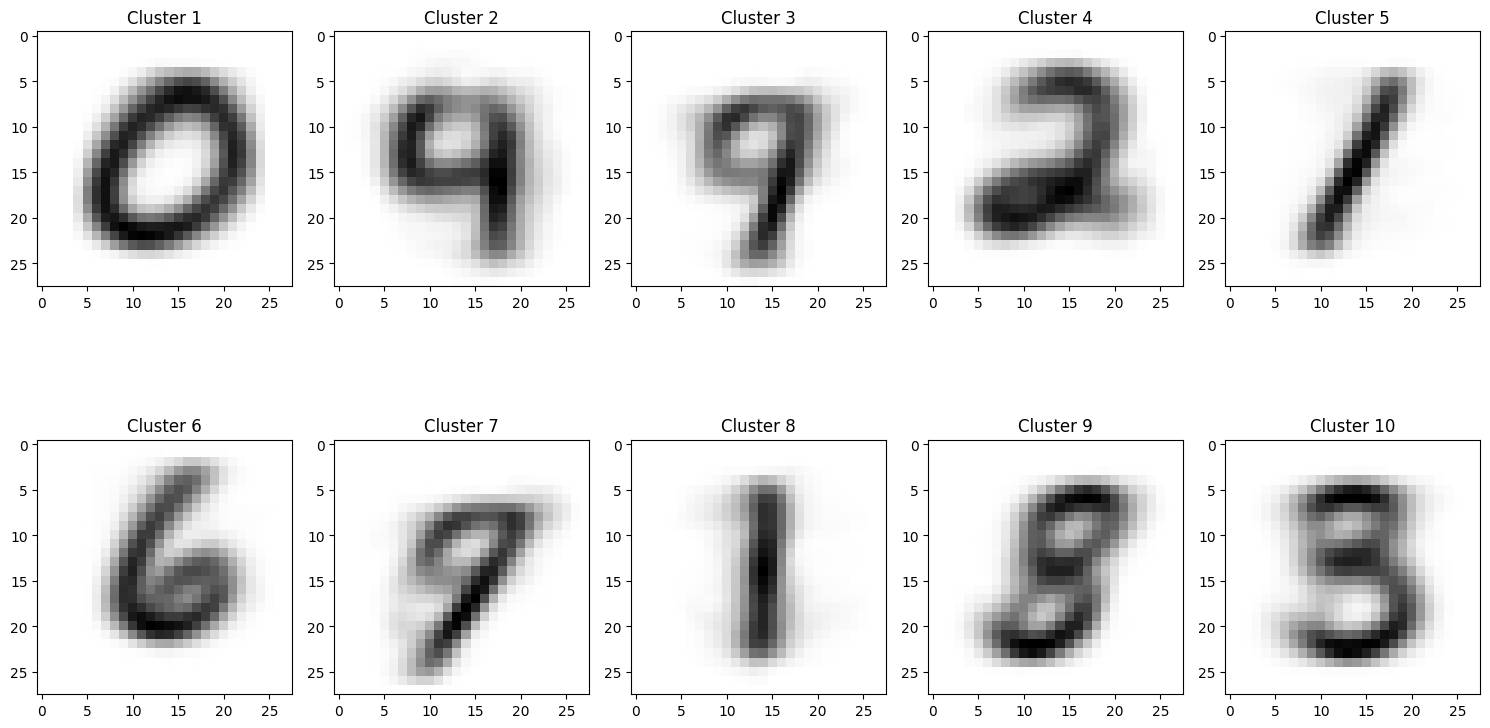

These are the learned cluster prototypes from K-means


In [4]:
# Plot cluster centers
fig, axes = plot_clusters(kmeans.cluster_centers_, rows=2)
plt.savefig('../results/kmeans_cluster_centers.png', dpi=150, bbox_inches='tight')
plt.show()

print("These are the learned cluster prototypes from K-means")

## 4. Analyze Cluster-Label Correspondence

Since we have ground truth labels, let's see how well clusters align with digit classes.

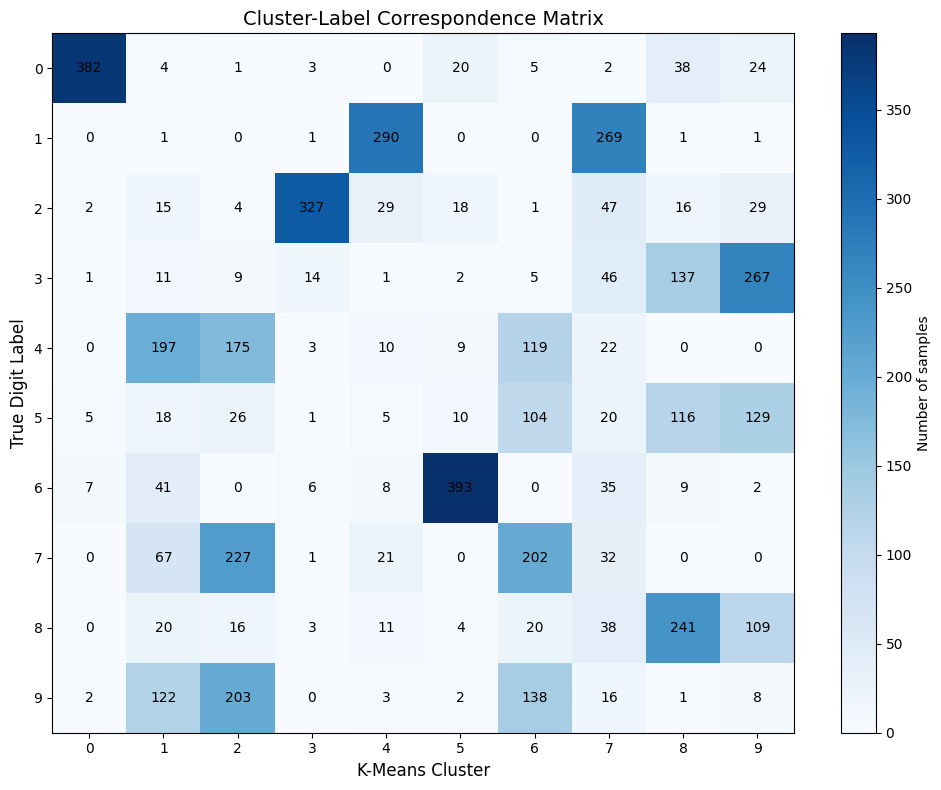

Each row shows how digits with a specific label are distributed across clusters
Ideally, each row would have one dominant cluster (perfect separation)


In [5]:
# Create confusion matrix: rows=true labels, cols=predicted clusters
confusion = np.zeros((10, 10), dtype=int)
for true_label in range(10):
    mask = y_train == true_label
    cluster_assignments = kmeans.labels_[mask]
    for cluster in range(10):
        confusion[true_label, cluster] = np.sum(cluster_assignments == cluster)

# Plot confusion matrix
fig, ax = plt.subplots(figsize=(10, 8))
im = ax.imshow(confusion, cmap='Blues', aspect='auto')

# Add text annotations
for i in range(10):
    for j in range(10):
        text = ax.text(j, i, confusion[i, j], ha="center", va="center", color="black")

ax.set_xlabel('K-Means Cluster', fontsize=12)
ax.set_ylabel('True Digit Label', fontsize=12)
ax.set_title('Cluster-Label Correspondence Matrix', fontsize=14)
ax.set_xticks(range(10))
ax.set_yticks(range(10))
plt.colorbar(im, ax=ax, label='Number of samples')
plt.tight_layout()
plt.savefig('../results/kmeans_confusion_matrix.png', dpi=150, bbox_inches='tight')
plt.show()

print("Each row shows how digits with a specific label are distributed across clusters")
print("Ideally, each row would have one dominant cluster (perfect separation)")

## 5. Calculate Clustering Purity

**Purity** measures the extent to which clusters contain samples from a single class.

In [6]:
def calculate_purity(labels_true, labels_pred):
    """Calculate clustering purity"""
    n_clusters = len(np.unique(labels_pred))
    n_samples = len(labels_true)
    
    purity_sum = 0
    for cluster in range(n_clusters):
        # Get true labels for this cluster
        cluster_mask = labels_pred == cluster
        cluster_true_labels = labels_true[cluster_mask]
        
        # Find most common true label in this cluster
        if len(cluster_true_labels) > 0:
            most_common_count = np.bincount(cluster_true_labels).max()
            purity_sum += most_common_count
    
    return purity_sum / n_samples

purity = calculate_purity(y_train, kmeans.labels_)
print(f"Clustering Purity: {purity:.3f}")
print(f"\nInterpretation: {purity*100:.1f}% of samples are in clusters dominated by their true class")
print(f"Random clustering would give ~10% purity (1/10 classes)")

Clustering Purity: 0.559

Interpretation: 55.9% of samples are in clusters dominated by their true class
Random clustering would give ~10% purity (1/10 classes)


## 6. Show Sample Cluster Members

Let's visualize what's actually in a few clusters.

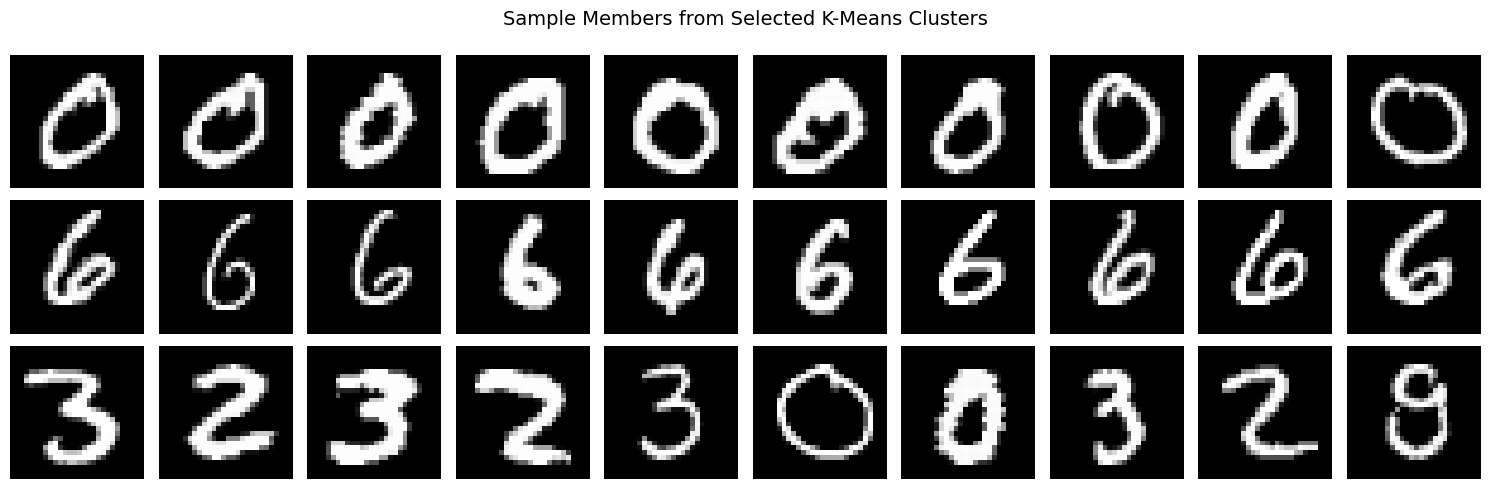

Notice some clusters contain similar-looking digits


In [7]:
# Show samples from 3 clusters
clusters_to_show = [0, 5, 9]

fig, axes = plt.subplots(len(clusters_to_show), 10, figsize=(15, 5))

for row, cluster_id in enumerate(clusters_to_show):
    # Get samples from this cluster
    cluster_indices = np.where(kmeans.labels_ == cluster_id)[0][:10]
    
    for col, idx in enumerate(cluster_indices):
        axes[row, col].imshow(X_train[idx].reshape(28, 28), cmap='gray')
        axes[row, col].axis('off')
        if col == 0:
            axes[row, col].set_ylabel(f'Cluster {cluster_id}', fontsize=12)

plt.suptitle('Sample Members from Selected K-Means Clusters', fontsize=14)
plt.tight_layout()
plt.savefig('../results/kmeans_cluster_samples.png', dpi=150, bbox_inches='tight')
plt.show()

print("Notice some clusters contain similar-looking digits")

## 7. Test Set Prediction

Apply the learned model to unseen test data.

In [8]:
# Predict on test set
test_predictions = kmeans.predict(X_test)

print(f"Predicted {len(test_predictions)} test samples")
print(f"Test set cluster distribution:")
unique, counts = np.unique(test_predictions, return_counts=True)
for cluster, count in zip(unique, counts):
    print(f"  Cluster {cluster}: {count} samples ({count/len(test_predictions)*100:.1f}%)")

# Calculate test set purity
test_purity = calculate_purity(y_test, test_predictions)
print(f"\nTest Set Purity: {test_purity:.3f}")
print(f"Training Set Purity: {purity:.3f}")
print(f"Difference: {abs(test_purity - purity):.3f} (similar performance = good generalization)")

Predicted 10000 test samples
Test set cluster distribution:
  Cluster 0: 828 samples (8.3%)
  Cluster 1: 923 samples (9.2%)
  Cluster 2: 1508 samples (15.1%)
  Cluster 3: 696 samples (7.0%)
  Cluster 4: 650 samples (6.5%)
  Cluster 5: 852 samples (8.5%)
  Cluster 6: 943 samples (9.4%)
  Cluster 7: 1118 samples (11.2%)
  Cluster 8: 1087 samples (10.9%)
  Cluster 9: 1395 samples (14.0%)

Test Set Purity: 0.558
Training Set Purity: 0.559
Difference: 0.001 (similar performance = good generalization)


## Summary

### K-Means Results:

- **Convergence**: Fast convergence in ~30-50 iterations
- **Cluster quality**: Purity shows clusters capture digit structure reasonably well
- **Hard assignments**: Each sample belongs to exactly one cluster
- **Limitations**: 
  - Cannot express uncertainty (sample might be between clusters)
  - Assumes spherical clusters (Euclidean distance)
  - Sensitive to initialization (we used random_state for reproducibility)